In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from model_settings import ms
from convsklearn import asian_trainer,barrier_trainer

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from convsklearn import barrier_trainer, asian_trainer
from feature_collector import collect_features, preprocess_data

root = Path().resolve().parent.parent

price_name = 'barrier_price' 
trainer = barrier_trainer
data_dir = os.path.join(root,ms.cboe_spx_barriers['dump'])
dataset = collect_features(data_dir,price_name)

dates = dataset['calculation_date'].copy().squeeze().drop_duplicates().reset_index(drop=True)
days = dates.dt.round('D').drop_duplicates()
days

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2122/2122 [00:20<00:00, 106.08it/s]


0      2024-10-16
17     2024-10-15
35     2024-10-14
40     2024-10-12
60     2024-10-11
          ...    
2039   2024-05-01
2054   2024-04-30
2077   2024-04-27
2096   2024-04-26
2105   2024-04-25
Name: calculation_date, Length: 135, dtype: datetime64[ns]

In [2]:
latest = days.iloc[1:2]
ante = days.iloc[2:3]
print(f"test:\n{ante},\n\ntrain:\n{latest}")

test:
35   2024-10-14
Name: calculation_date, dtype: datetime64[ns],

train:
17   2024-10-15
Name: calculation_date, dtype: datetime64[ns]


20 20


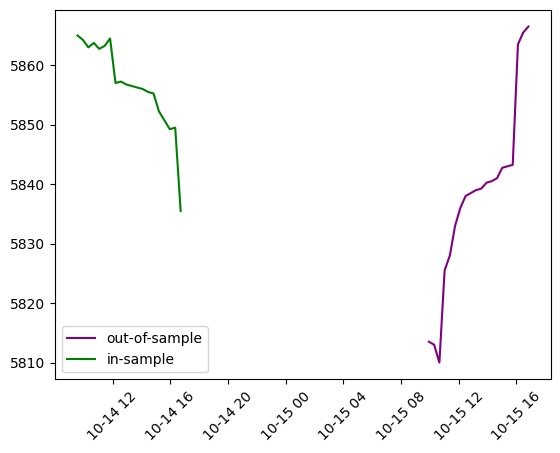

41738 41738


In [3]:
development_dates = dates[dates.dt.normalize().isin(ante)]#.iloc[-1:]
test_dates = dates[dates.dt.normalize().isin(latest)]#.iloc[:1]
print(len(development_dates),len(test_dates))
preprocessed = preprocess_data(dataset,development_dates,test_dates,trainer)
preprocessed.keys()
preprocessor = preprocessed['preprocessor']
train_test = preprocessed['train_test_arrays']
train_X = train_test['train_X']
train_y = train_test['train_y']

In [4]:
trainer.feature_set

['spot_price',
 'strike_price',
 'days_to_maturity',
 'risk_free_rate',
 'dividend_rate',
 'kappa',
 'theta',
 'rho',
 'eta',
 'v0',
 'barrier',
 'barrier_type_name',
 'w']

In [5]:
numerical_scaler = StandardScaler()

feature_transformers = [
        ('numerical', numerical_scaler, trainer.numerical_features),
        ('categorical', OneHotEncoder(sparse_output=False), trainer.categorical_features)
    ]

In [6]:
preprocessor = ColumnTransformer(
    transformers=feature_transformers
)

dnn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('dnn', MLPRegressor(**trainer.dnn_params))
])

scaled_dnn = TransformedTargetRegressor(
    regressor=dnn_pipeline,
    transformer=numerical_scaler
)

In [ ]:
param_grid = {
    # 'regressor__dnn__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'regressor__dnn__solver': ['lbfgs', 'sgd',],
    'regressor__dnn__alpha': [0.0001, 0.001, 0.01, 0.1],
    'regressor__dnn__batch_size': ['auto', 32, 64, 128],
    'regressor__dnn__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'regressor__dnn__learning_rate_init': [0.001, 0.01, 0.1],
    # 'regressor__dnn__power_t': [0.5, 0.25],
    # 'regressor__dnn__max_iter': [200, 500, 1000],
    # 'regressor__dnn__shuffle': [True, False],
    # 'regressor__dnn__tol': [1e-4, 1e-3, 1e-2],
    'regressor__dnn__warm_start': [False, True],
    # 'regressor__dnn__momentum': [0.9, 0.8, 0.7],
    # 'regressor__dnn__nesterovs_momentum': [True, False],
    'regressor__dnn__early_stopping': [False, True],
    # 'regressor__dnn__validation_fraction': [0.1, 0.15, 0.2],
    # 'regressor__dnn__beta_1': [0.9, 0.85],
    # 'regressor__dnn__beta_2': [0.999, 0.99],
    # 'regressor__dnn__epsilon': [1e-8, 1e-6],
    # 'regressor__dnn__n_iter_no_change': [10, 20],
    # 'regressor__dnn__max_fun': [15000, 20000]
}

grid_search = GridSearchCV(
    estimator=scaled_dnn,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=max(1,os.cpu_count()//4),
    verbose=1
)

grid_search.fit(train_X, train_y)

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
